# Case-based analysis of CGAN ensemble mean

This notebook provides two example cases that illustrate the strengths and weaknesses of CNN-based severe weather prediction with CGANs. 

* In the successful example of 4 May 2021, the CGAN ensemble mean produced more skillful forecasts for grid cells with severe weather reports but do not have high-UH. Indicating that the CGAN ensemble can detect severe weather from other environmental predictors.

* In the bad example of 24 August 2021, the CGAN ensemble mean exhibited negative BSS because its CNN is more sensitive to the spatial error of CAM inputs. The CGAN-generated samples also amplified such spatial error, resulting high severe weather probabilities on the biased locations

In [ ]:
# general tools
import os
import re
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
from scipy.spatial import cKDTree
from sklearn.metrics import brier_score_loss

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [5]:
need_publish = True

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [6]:
tags = ['gan', 'base', 'mlp']
leads = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
L = len(leads)

with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]

IND_TEST_lead = np.load('/glade/work/ksha/NCAR/IND_TEST_lead_v4.npy', allow_pickle=True)[()]
save_dir = '/glade/work/ksha/NCAR/'

In [8]:
with h5py.File(save_dir+'CNN_ExWeather_HRRRv4_2021.hdf', 'r') as h5io:
    STD_SAVE = h5io['y_std'][...]
    PRED_SAVE = h5io['y_pred'][...]
    TRUE_SAVE = h5io['y_true'][...]
    leads = h5io['lead_times'][...]

In [ ]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [ ]:
colors_sub = np.array([[248, 206, 204], [218, 232, 252], [213, 232, 212]])/255
colors_main = [red, blue, green]

gray_main = np.array([102, 102, 102])/255
gray_sub = np.array([245, 245, 245])/255

cmap_pct, A = gu.precip_cmap()
cmap_prob = cmap_pct
cmap_uh = cmap_pct #plt.cm.get_cmap('prcp_2')
cmap_cape = cmap_pct #plt.cm.get_cmap('spread_15lev')#('wind_17lev')
cmap_mslp = cmap_pct #plt.cm.get_cmap('CBR_coldhot')

In [11]:
import zarr
import dask.array as da

## Successful example

**Identify this example**

In [12]:
lead = 2

diff_ = np.nanmean(np.abs(TRUE_SAVE - PRED_SAVE), axis=(2, 3))
cases_ = np.nansum(TRUE_SAVE[..., 0], axis=(2, 3))
diff_pick = diff_[:, 0, 0] - diff_[:, 0, 1]
inds_ = np.logical_and((diff_pick > 3e-3), (cases_[:, 0] > 10))

day = np.arange(365)[inds_][0]

In [14]:
DATA = np.load('/glade/work/ksha/NCAR/CNN_ExWeather_example_lead{}_day{}.npy'.format(lead, day+29))
LABEL = np.load('/glade/work/ksha/NCAR/CNN_ExWeather_example_lead{}_day{}_label.npy'.format(lead, day+29))

**Compute BSS**

In [17]:
true_grid_v = TRUE_SAVE[:, lead-2, ...]
prob_grid_v = PRED_SAVE[:, lead-2, ...]

label_ = LABEL>0

for i in range(3):
    obar_ = np.mean(label_[land_mask_80km])
    bs_ = brier_score_loss(label_[land_mask_80km], prob_grid_v[day, ..., i][land_mask_80km])
    bss_ = (obar_-bs_)/obar_
    print(bss_)

0.36255324223473684
0.3491312808414048
0.2580096593158277


**Figure**

In [24]:
date_list_v4[123]

datetime.datetime(2021, 4, 5, 0, 0)

Text(0.0, 0.5, 'High-pressure center')

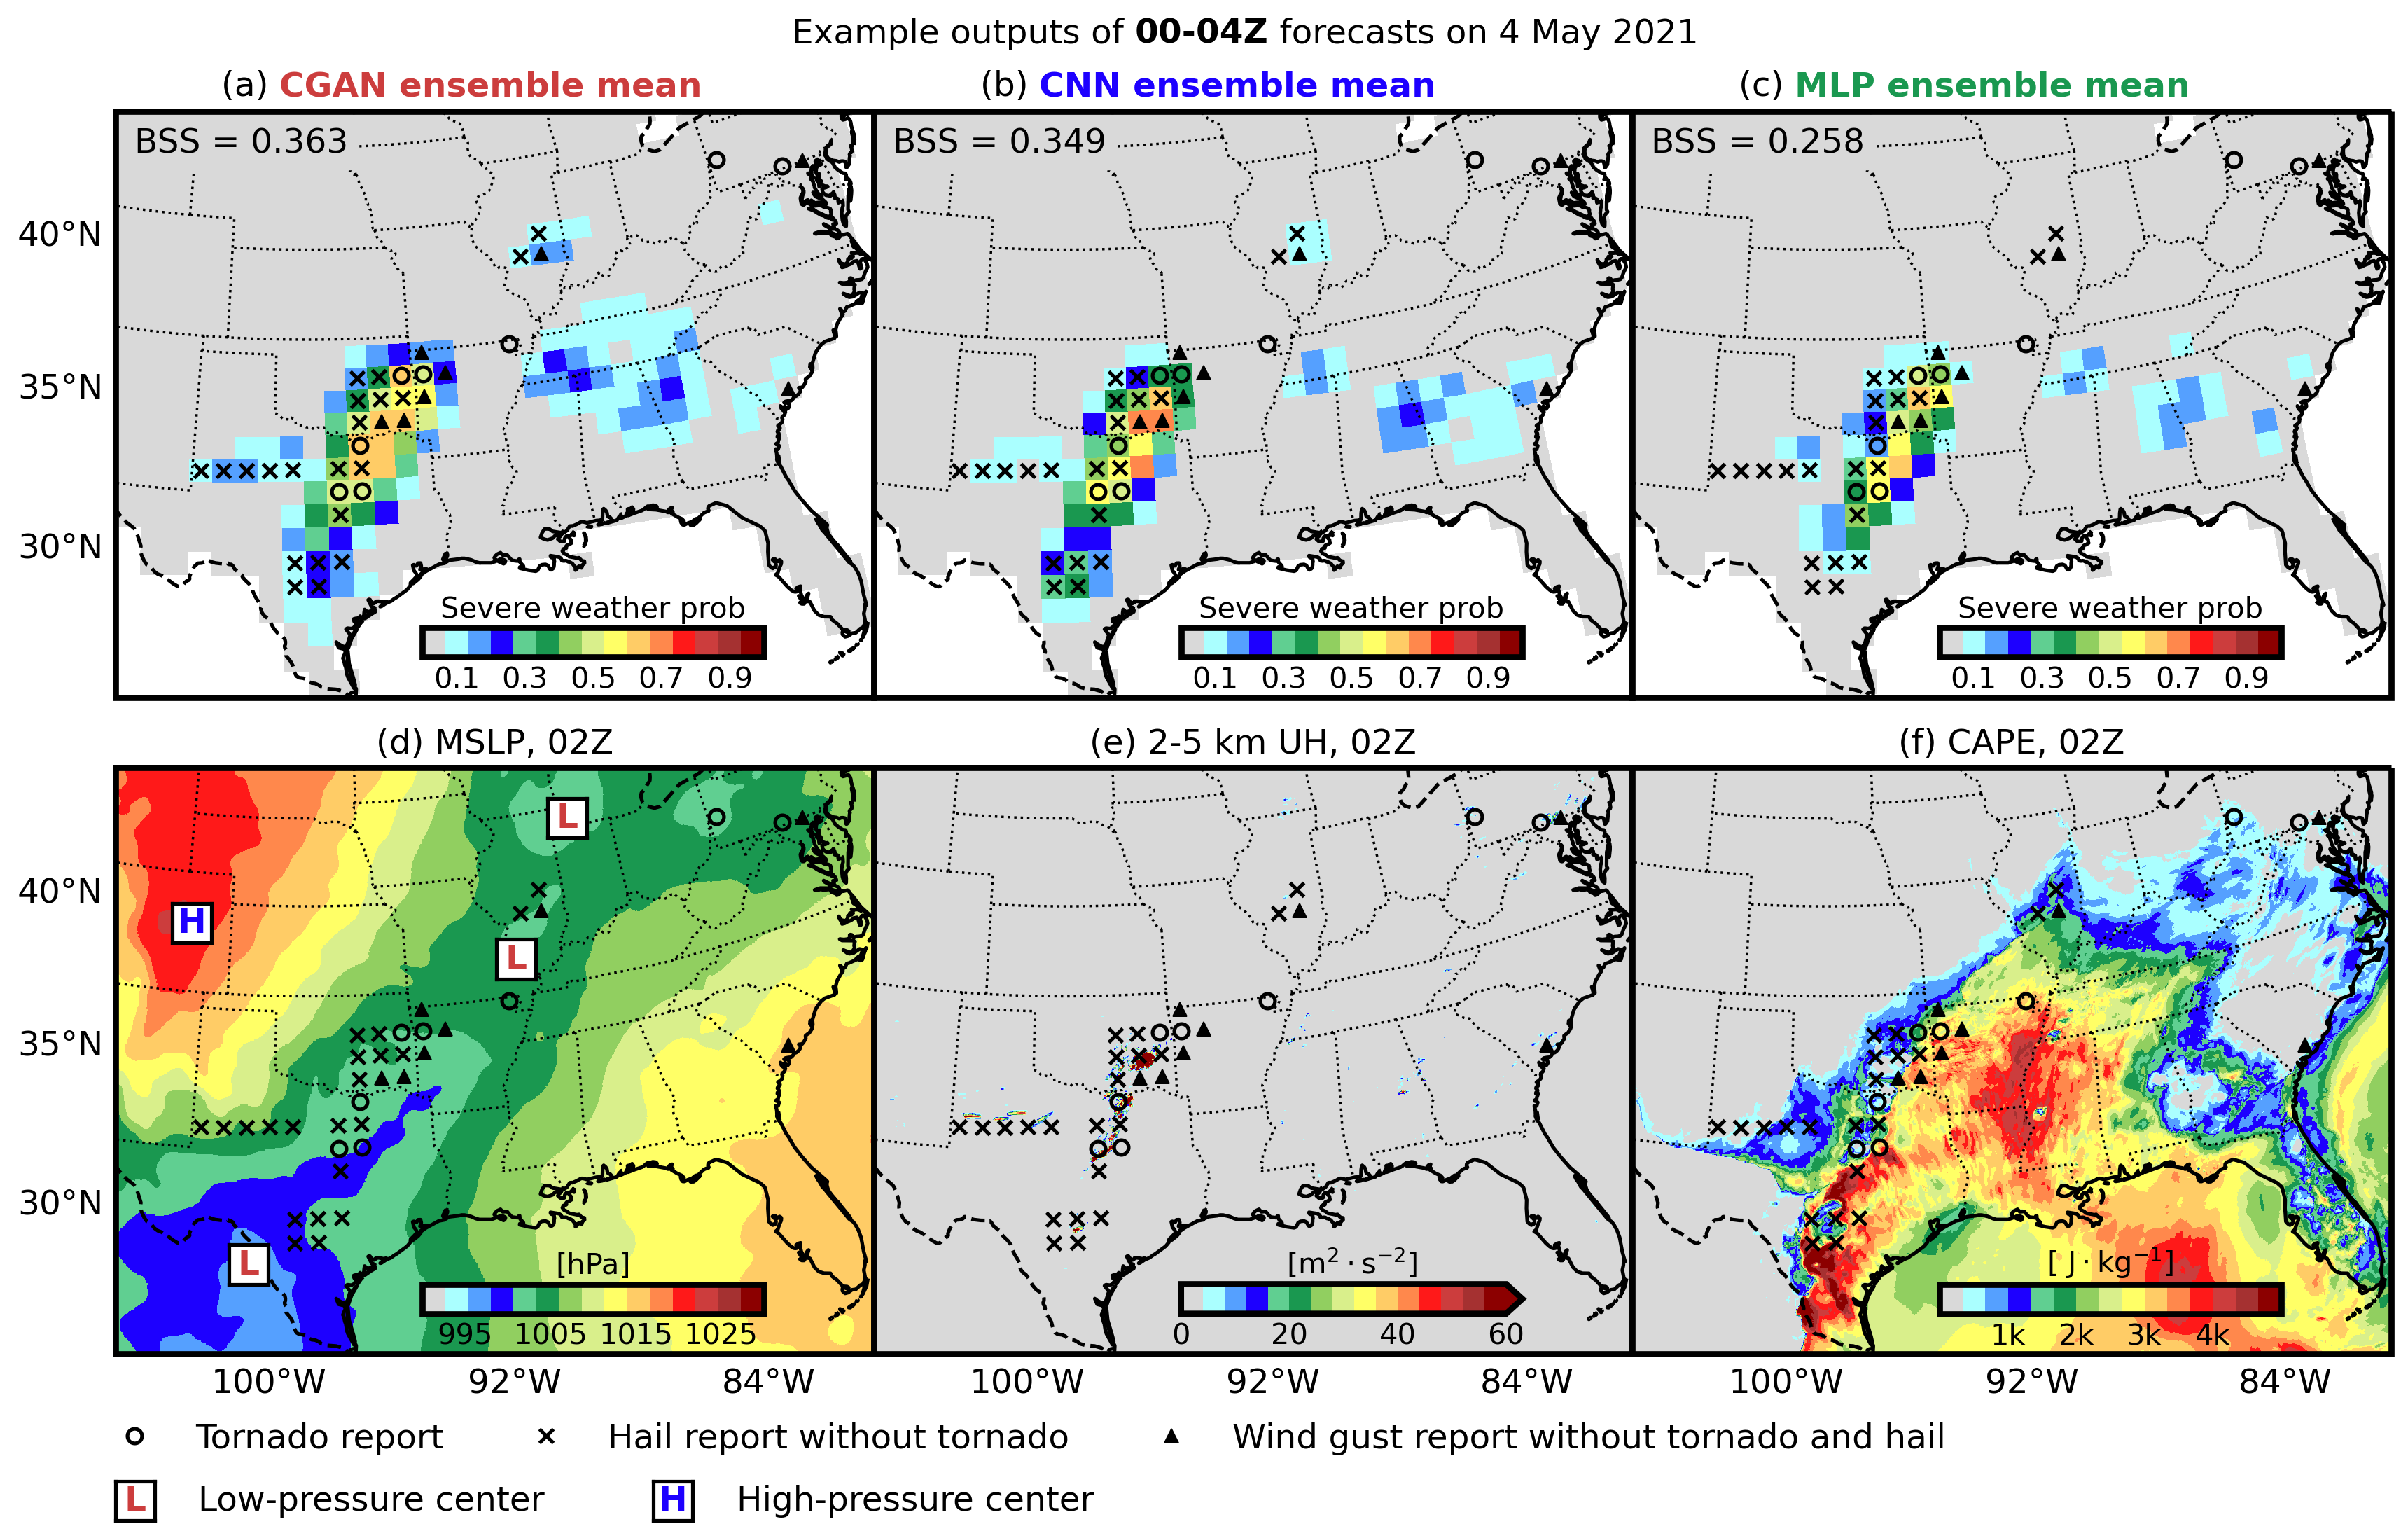

In [25]:
edge = [-105, -80, 25.5, 42.5]

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ind_lead = lead-2
date_list_v4 = [datetime(2021, 1, 1) + timedelta(days=day) for day in range(365)]

true_grid_v = TRUE_SAVE[:, ind_lead, ...]
prob_grid_v = PRED_SAVE[:, ind_lead, ...]
std_grid_v = STD_SAVE[:, ind_lead, ...]

# record_temp = true_grid_v[day, ..., 0]

lon_torn = lon_80km[LABEL==1]
lat_torn = lat_80km[LABEL==1]

lon_wind = lon_80km[LABEL==2]
lat_wind = lat_80km[LABEL==2]

lon_hail = lon_80km[LABEL==3]
lat_hail = lat_80km[LABEL==3]

label_ = LABEL>0
obar_ = np.mean(label_[land_mask_80km])

fig = plt.figure(figsize=(13, 7.5), dpi=dpi_) #, dpi=dpi_
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ax1 = plt.subplot(gs[0, 0], projection=proj_)
ax2 = plt.subplot(gs[0, 1], projection=proj_)
ax3 = plt.subplot(gs[0, 2], projection=proj_)

ax4 = plt.subplot(gs[1, 0], projection=proj_)
ax5 = plt.subplot(gs[1, 1], projection=proj_)
ax6 = plt.subplot(gs[1, 2], projection=proj_)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

for ax in [ax4, ax5, ax6]:
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    GL.left_labels = None
    GL.xlocator = mticker.FixedLocator([-100, -92, -84])
    GL.ylocator = mticker.FixedLocator([30, 35, 40, 45])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
for ax in [ax1, ax4]:
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    GL.bottom_labels = None
    GL.xlocator = mticker.FixedLocator([-100, -92, -84])
    GL.ylocator = mticker.FixedLocator([30, 35, 40, 45])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
    
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.0, zorder=5)

# label_ = LABEL

for i, ax in enumerate([ax1, ax2, ax3]):
    CS = ax.pcolormesh(lon_80km, lat_80km, prob_grid_v[day, ..., i], vmin=0, vmax=1.0, cmap=cmap_prob, transform=ccrs.PlateCarree())
    
    bs_ = brier_score_loss(label_[land_mask_80km], prob_grid_v[day, ..., i][land_mask_80km])
    bss_ = (obar_-bs_)/obar_

    
    handle = ax.text(0.025, 0.93, 'BSS = {:.3f}'.format(bss_), fontsize=14, zorder=6, transform=ax.transAxes)
    handle.set_bbox(dict(facecolor='0.85', edgecolor='0.85'))

CS1 = ax4.pcolormesh(lon_3km, lat_3km, DATA[..., 1]/100, vmin=990, vmax=1030, cmap=cmap_mslp, transform=ccrs.PlateCarree())
CS2 = ax5.pcolormesh(lon_3km, lat_3km, DATA[..., 3], vmin=0, vmax=60, cmap=cmap_uh, transform=ccrs.PlateCarree())
CS3 = ax6.pcolormesh(lon_3km, lat_3km, DATA[..., 15], vmin=0, vmax=5000, cmap=cmap_cape, transform=ccrs.PlateCarree())

Handles = []

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    Handles += ax.plot(lon_torn, lat_torn, 'ko', ms=6, mec='k', mew=1.5, mfc='none', 
                       zorder=6, transform=ccrs.PlateCarree(), label='Tornado report')
    Handles += ax.plot(lon_hail, lat_hail, 'kx', ms=6, mec='k', mew=1.5, mfc='k', 
                       zorder=6, transform=ccrs.PlateCarree(), label='Hail report without tornado')
    # Handles += ax.plot(lon_hail, lat_hail, linewidth=0, marker='$\mathrm{A}$', ms=7, mec='k', mew=0.65, mfc='k', 
    #                    zorder=6, transform=ccrs.PlateCarree(), label='Hail report without tornado')
    Handles += ax.plot(lon_wind, lat_wind, 'k^', ms=6, mec='k', mew=0.5, mfc='k', 
                       zorder=6, transform=ccrs.PlateCarree(), label='Wind gust report without tornado and hail')

y_ = 0.985
x_ = 0.14
ax_t1 = fig.add_axes([0, y_, 1/3, 0.02])
ax_t1.set_axis_off()
gu.string_partial_format(fig, ax_t1, x_, 1.0, 'left', 'top', ['(a) ' , 'CGAN ensemble mean'], 
                         ['k', colors_main[0]], [14, 14], ['normal', 'bold']);

ax_t2 = fig.add_axes([1/3, y_, 1/3, 0.02])
ax_t2.set_axis_off()
gu.string_partial_format(fig, ax_t2, x_, 1.0, 'left', 'top', ['(b) ' , 'CNN ensemble mean'], 
                         ['k', colors_main[1]], [14, 14], ['normal', 'bold']);

ax_t3 = fig.add_axes([2/3, y_, 1/3, 0.02])
ax_t3.set_axis_off()
gu.string_partial_format(fig, ax_t3, x_, 1.0, 'left', 'top', ['(c) ' , 'MLP ensemble mean'], 
                         ['k', colors_main[2]], [14, 14], ['normal', 'bold']);

ax4.set_title('(d) MSLP, 02Z', fontsize=14)
ax5.set_title('(e) 2-5 km UH, 02Z', fontsize=14)
ax6.set_title('(f) CAPE, 02Z', fontsize=14)

ax_all = fig.add_axes([0.5-(0.5*0.405), 1.025, 0.405, 0.02])
ax_all.set_axis_off()
gu.string_partial_format(fig, ax_all, 0.0, 1.0, 'left', 'top', 
                 ['Example outputs of ', '00-04Z', ' forecasts on ', '4 May 2021'],
                 ['k',]*4, [14,]*4, ['normal', 'bold', 'normal', 'normal']);

pos_y_ = 0.035

ax_base = fig.add_axes([0.135, pos_y_+0.5, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0.1, 0.3, 0.5, 0.7, 0.9], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, 'Severe weather prob', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([0.135+1/3, pos_y_+0.5, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0.1, 0.3, 0.5, 0.7, 0.9], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, 'Severe weather prob', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([0.135+2/3, pos_y_+0.5, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0.1, 0.3, 0.5, 0.7, 0.9], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, 'Severe weather prob', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([0.135, pos_y_, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS1, orientation='horizontal', ticks=[995, 1005, 1015, 1025], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, '[hPa]', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([0.135+1/3, pos_y_, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS2, orientation='horizontal', ticks=[0, 20, 40, 60], extend='max', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, '[$\mathsf{m^2 \cdot s^{-2}}$]', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([0.135+2/3, pos_y_, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS3, orientation='horizontal', ticks=[1000, 2000, 3000, 4000], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['1k', '2k', '3k', '4k']);
ax_base.text(0.5, 1.075, '[ $\mathsf{J \cdot kg^{-1}}$]', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_lg1 = fig.add_axes([-0.02, -0.065, 1.0, 0.055])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=Handles[:3], bbox_to_anchor=(0.0, 0.5), ncol=3, loc=6, 
                    prop={'size':14}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

ax_L2 = fig.add_axes([0.05, 0.08, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_L2.spines.values()]
ax_L2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_L2.text(0.5, 0.5, 'L', ha='center', va='center', color=red, fontsize=14, fontweight='bold', transform=ax_L2.transAxes)

ax_L1 = fig.add_axes([0.1675, 0.3125, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_L1.spines.values()]
ax_L1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_L1.text(0.5, 0.5, 'L', ha='center', va='center', color=red, fontsize=14, fontweight='bold', transform=ax_L1.transAxes)

ax_L3 = fig.add_axes([0.19, 0.42, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_L3.spines.values()]
ax_L3.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_L3.text(0.5, 0.5, 'L', ha='center', va='center', color=red, fontsize=14, fontweight='bold', transform=ax_L3.transAxes)


ax_H1 = fig.add_axes([0.025, 0.34, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_H1.spines.values()]
ax_H1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_H1.text(0.5, 0.5, 'H', ha='center', va='center', color=blue, fontsize=14, fontweight='bold', transform=ax_H1.transAxes)

# --------- symbol legends --------- #

d_ = 0.0365
ax_sym1 = fig.add_axes([0, -0.1, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_sym1.spines.values()]
ax_sym1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_sym1.text(0.5, 0.5, 'L', ha='center', va='center', color=red, fontsize=14, fontweight='bold', transform=ax_sym1.transAxes)

ax_sym_lg1 = fig.add_axes([d_, -0.1, 0.2, 0.03])
ax_sym_lg1.set_axis_off()
ax_sym_lg1.text(0.0, 0.5, 'Low-pressure center', ha='left', va='center', fontsize=14, transform=ax_sym_lg1.transAxes)

ax_sym2 = fig.add_axes([0.2+d_, -0.1, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_sym2.spines.values()]
ax_sym2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_sym2.text(0.5, 0.5, 'H', ha='center', va='center', color=blue, fontsize=14, fontweight='bold', transform=ax_sym2.transAxes)

ax_sym_lg2 = fig.add_axes([0.2+d_+d_, -0.1, 0.2, 0.03])
ax_sym_lg2.set_axis_off()
ax_sym_lg2.text(0.0, 0.5, 'High-pressure center', ha='left', va='center', fontsize=14, transform=ax_sym_lg2.transAxes)

## Bad example

**Identify this example**

In [27]:
lead = 19

In [28]:
diff_ = np.nanmean(np.abs(TRUE_SAVE[:, :, land_mask_80km, :] - PRED_SAVE[:, :, land_mask_80km, :]), axis=2)
cases_ = np.nansum(TRUE_SAVE[..., 0], axis=(2, 3))
diff_pick = diff_[:, lead-2, 0] - diff_[:, lead-2, 2]
inds_ = diff_pick > 5e-3

day = np.arange(365)[inds_][22]
LABEL = np.load('/glade/work/ksha/NCAR/CNN_ExWeather_example_lead{}_day{}_label.npy'.format(lead, day+29))
DATA = np.load('/glade/work/ksha/NCAR/CNN_ExWeather_example_lead{}_day{}.npy'.format(lead, day+29))

/glade/scratch/ksha/ipykernel_300503/4166862599.py:1: RuntimeWarning: Mean of empty slice
  diff_ = np.nanmean(np.abs(TRUE_SAVE[:, :, land_mask_80km, :] - PRED_SAVE[:, :, land_mask_80km, :]), axis=2)


**Compute BSS**

In [34]:
true_grid_v = TRUE_SAVE[:, lead-2, ...]
prob_grid_v = PRED_SAVE[:, lead-2, ...]

label_ = LABEL>0

for i in range(3):
    obar_ = np.mean(label_[land_mask_80km])
    bs_ = brier_score_loss(label_[land_mask_80km], prob_grid_v[day, ..., i][land_mask_80km])
    bss_ = (obar_-bs_)/obar_
    print(bss_)

-0.5141946151670773
-0.2918831431761361
-0.008991246217687278


**Figure**

In [38]:
date_list_v4[day]

datetime.datetime(2021, 8, 24, 0, 0)

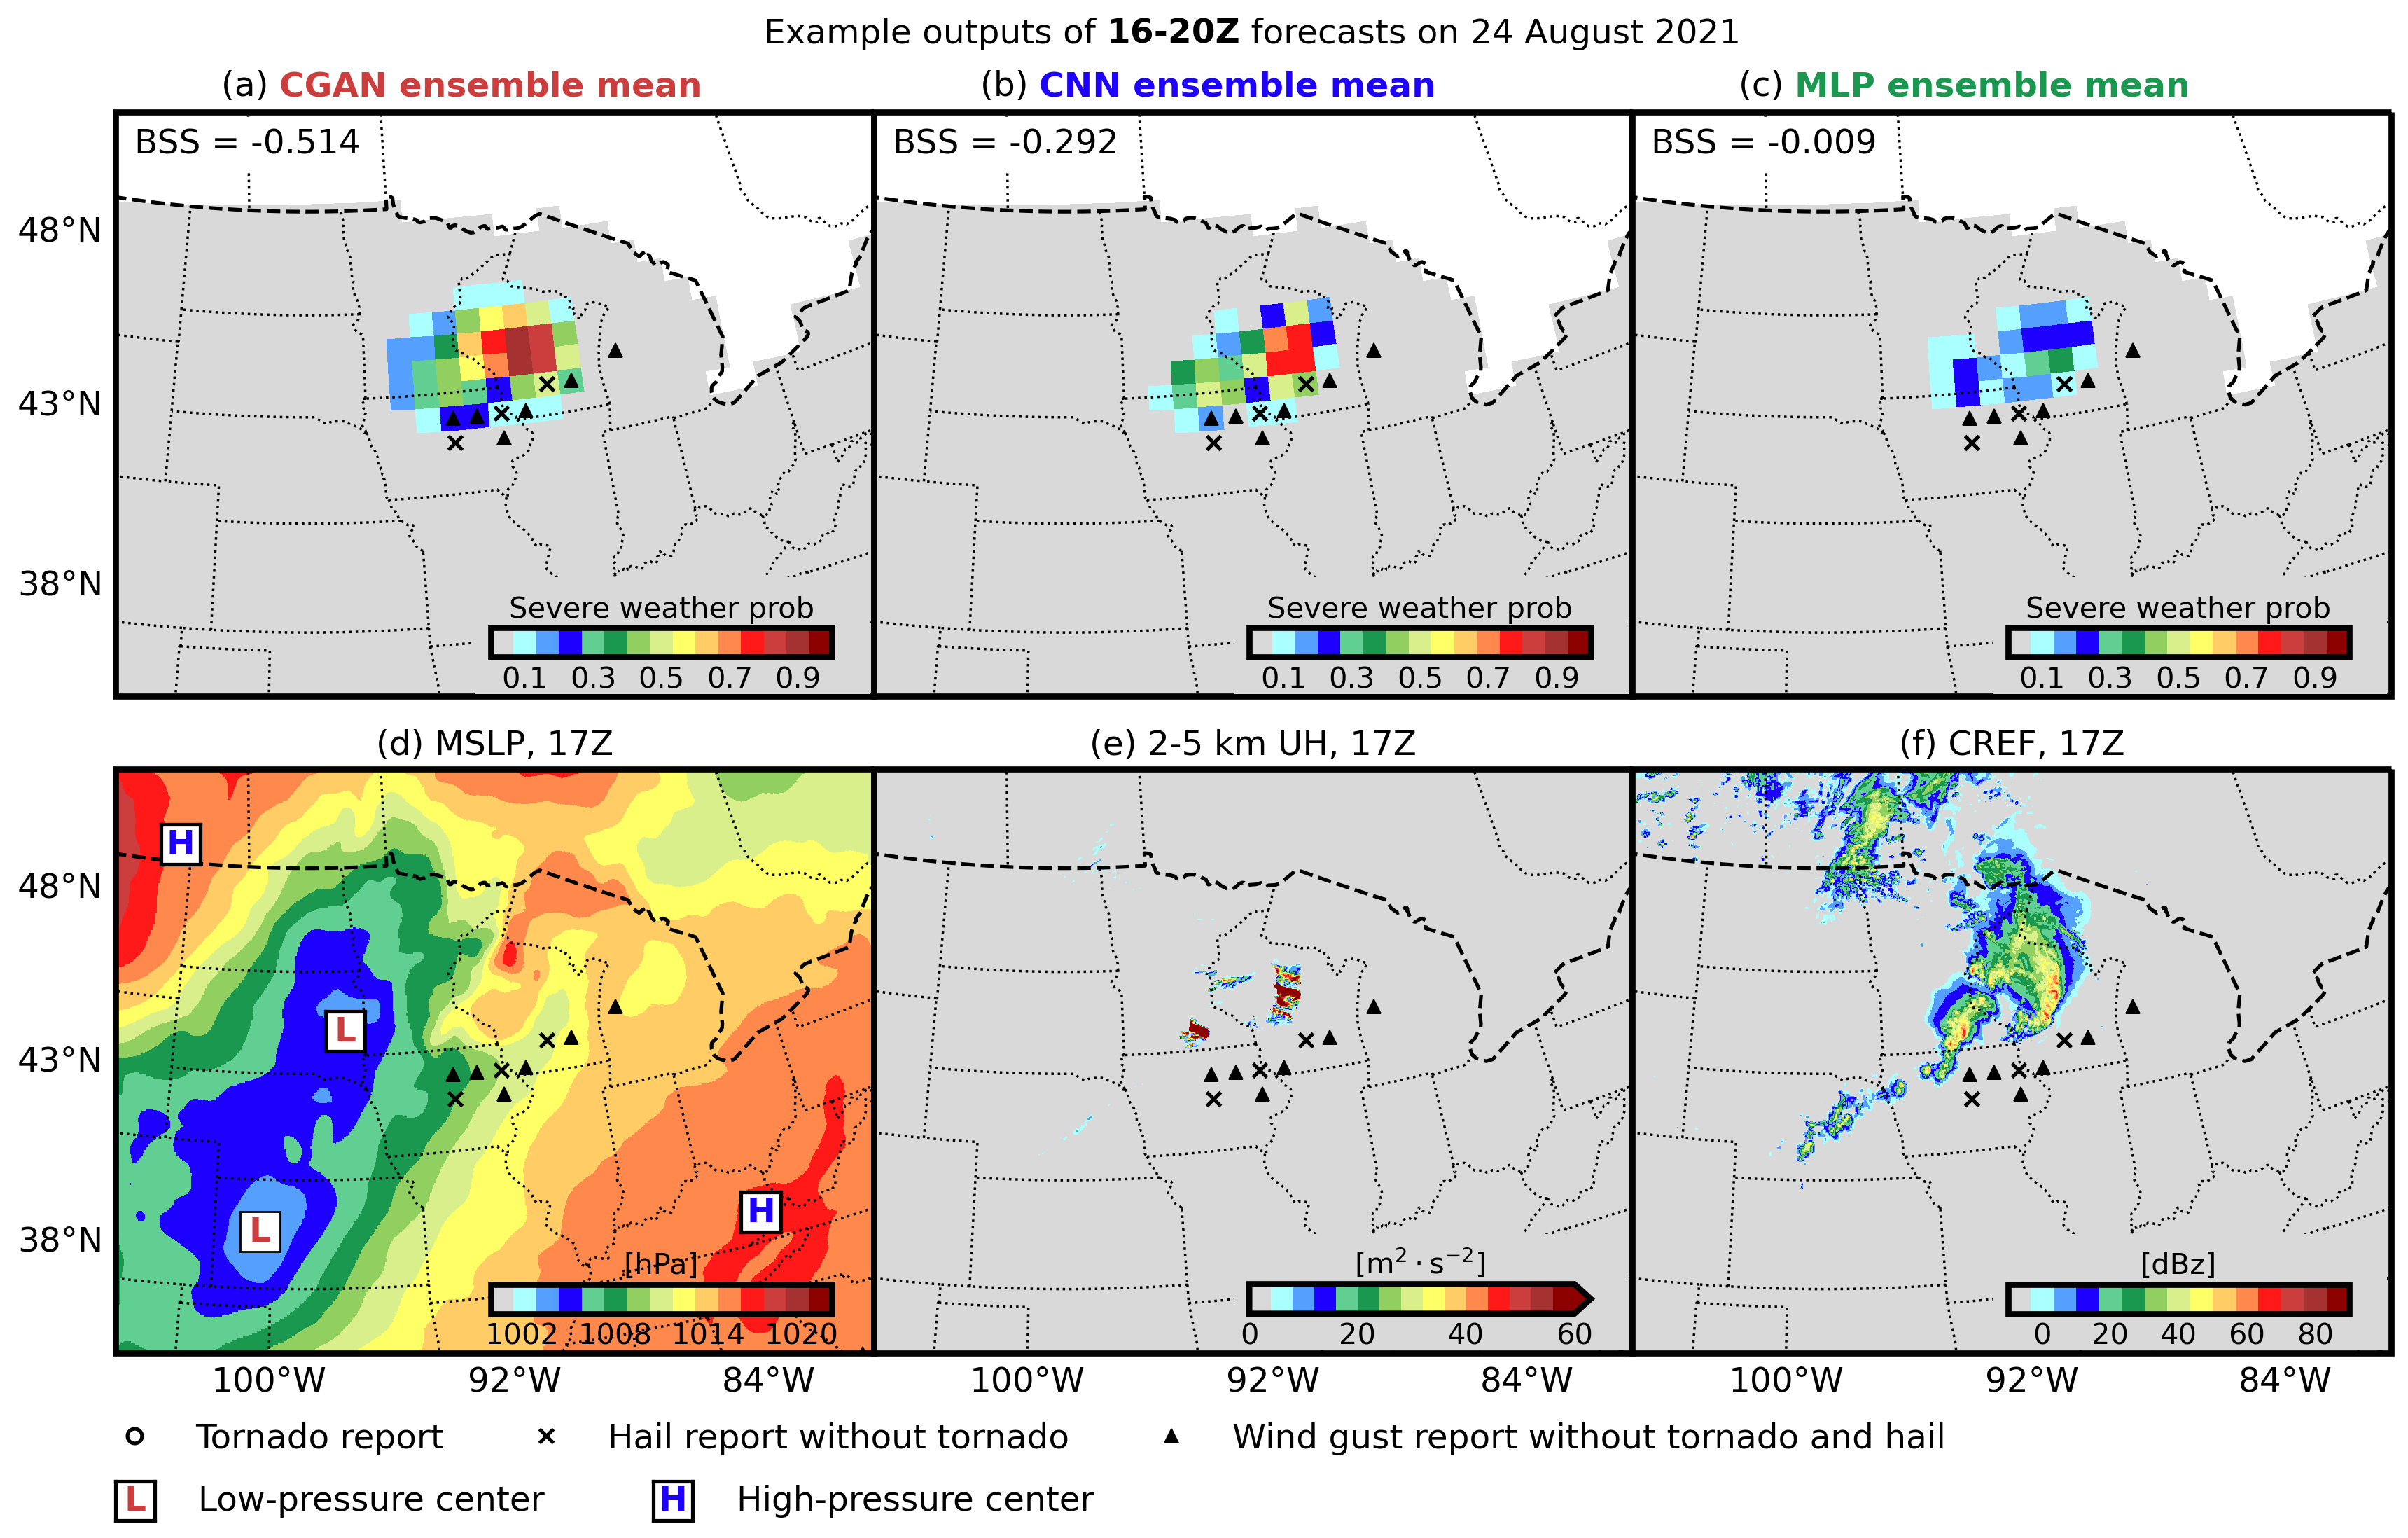

In [39]:
edge = [-105, -80, 25.5+7.5+2.0, 42.5+7.5]

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

ind_lead = lead-2
date_list_v4 = [datetime(2021, 1, 1) + timedelta(days=day) for day in range(365)]

true_grid_v = TRUE_SAVE[:, ind_lead, ...]
prob_grid_v = PRED_SAVE[:, ind_lead, ...]
std_grid_v = STD_SAVE[:, ind_lead, ...]

# record_temp = true_grid_v[day, ..., 0]

lon_torn = lon_80km[LABEL==1]
lat_torn = lat_80km[LABEL==1]

lon_wind = lon_80km[LABEL==2]
lat_wind = lat_80km[LABEL==2]

lon_hail = lon_80km[LABEL==3]
lat_hail = lat_80km[LABEL==3]

label_ = LABEL>0
obar_ = np.mean(label_[land_mask_80km])

fig = plt.figure(figsize=(13, 7.5), dpi=dpi_) #, dpi=dpi_
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)


ax1 = plt.subplot(gs[0, 0], projection=proj_)
ax2 = plt.subplot(gs[0, 1], projection=proj_)
ax3 = plt.subplot(gs[0, 2], projection=proj_)

ax4 = plt.subplot(gs[1, 0], projection=proj_)
ax5 = plt.subplot(gs[1, 1], projection=proj_)
ax6 = plt.subplot(gs[1, 2], projection=proj_)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

for ax in [ax4, ax5, ax6]:
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    GL.left_labels = None
    GL.xlocator = mticker.FixedLocator([-100, -92, -84])
    GL.ylocator = mticker.FixedLocator([37, 42, 47])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
for ax in [ax1, ax4]:
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    GL.bottom_labels = None
    GL.xlocator = mticker.FixedLocator([-100, -92, -84])
    GL.ylocator = mticker.FixedLocator([38, 43, 48])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    
    
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.0, zorder=5)

# label_ = LABEL

for i, ax in enumerate([ax1, ax2, ax3]):
    CS = ax.pcolormesh(lon_80km, lat_80km, prob_grid_v[day, ..., i], vmin=0, vmax=1.0, cmap=cmap_prob, transform=ccrs.PlateCarree())
    
    bs_ = brier_score_loss(label_[land_mask_80km], prob_grid_v[day, ..., i][land_mask_80km])
    bss_ = (obar_-bs_)/obar_
    
    handle = ax.text(0.025, 0.93, 'BSS = {:.3f}'.format(bss_), fontsize=14, zorder=6, transform=ax.transAxes)
    handle.set_bbox(dict(facecolor='w', edgecolor='w'))

CS1 = ax4.pcolormesh(lon_3km, lat_3km, DATA[..., 1]/100, vmin=1000, vmax=1022, cmap=cmap_mslp, transform=ccrs.PlateCarree())
CS2 = ax5.pcolormesh(lon_3km, lat_3km, DATA[..., 3], vmin=0, vmax=60, cmap=cmap_uh, transform=ccrs.PlateCarree())
CS3 = ax6.pcolormesh(lon_3km, lat_3km, DATA[..., 0], vmin=-10, vmax=90, cmap=cmap_cape, transform=ccrs.PlateCarree())

Handles = []

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    Handles += ax.plot(lon_torn, lat_torn, 'ko', ms=6, mec='k', mew=1.5, mfc='none', 
                       zorder=6, transform=ccrs.PlateCarree(), label='Tornado report')
    Handles += ax.plot(lon_hail, lat_hail, 'kx', ms=6, mec='k', mew=1.5, mfc='k', 
                       zorder=6, transform=ccrs.PlateCarree(), label='Hail report without tornado')
    Handles += ax.plot(lon_wind, lat_wind, 'k^', ms=6, mec='k', mew=0.5, mfc='k', 
                       zorder=6, transform=ccrs.PlateCarree(), label='Wind gust report without tornado and hail')

y_ = 0.985
x_ = 0.14
ax_t1 = fig.add_axes([0, y_, 1/3, 0.02])
ax_t1.set_axis_off()
gu.string_partial_format(fig, ax_t1, x_, 1.0, 'left', 'top', ['(a) ' , 'CGAN ensemble mean'], 
                         ['k', colors_main[0]], [14, 14], ['normal', 'bold']);

ax_t2 = fig.add_axes([1/3, y_, 1/3, 0.02])
ax_t2.set_axis_off()
gu.string_partial_format(fig, ax_t2, x_, 1.0, 'left', 'top', ['(b) ' , 'CNN ensemble mean'], 
                         ['k', colors_main[1]], [14, 14], ['normal', 'bold']);

ax_t3 = fig.add_axes([2/3, y_, 1/3, 0.02])
ax_t3.set_axis_off()
gu.string_partial_format(fig, ax_t3, x_, 1.0, 'left', 'top', ['(c) ' , 'MLP ensemble mean'], 
                         ['k', colors_main[2]], [14, 14], ['normal', 'bold']);

ax4.set_title('(d) MSLP, 17Z', fontsize=14)
ax5.set_title('(e) 2-5 km UH, 17Z', fontsize=14)
ax6.set_title('(f) CREF, 17Z', fontsize=14)

ax_all = fig.add_axes([0.5-(0.5*0.43), 1.025, 0.43, 0.02])
ax_all.set_axis_off()
gu.string_partial_format(fig, ax_all, 0.0, 1.0, 'left', 'top', 
                 ['Example outputs of ', '16-20Z', ' forecasts on ', '24 August 2021'],
                 ['k',]*4, [14,]*4, ['normal', 'bold', 'normal', 'normal']);

pos_y_ = 0.035
pos_x_ = 0.165

ax_base = fig.add_axes([pos_x_, pos_y_+0.5, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
#ax_base.set_facecolor('0.85')
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0.1, 0.3, 0.5, 0.7, 0.9], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, 'Severe weather prob', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([pos_x_+1/3, pos_y_+0.5, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
#ax_base.set_facecolor('0.85')
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0.1, 0.3, 0.5, 0.7, 0.9], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, 'Severe weather prob', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([pos_x_+2/3, pos_y_+0.5, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
#ax_base.set_facecolor('0.85')
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0.1, 0.3, 0.5, 0.7, 0.9], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, 'Severe weather prob', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([pos_x_, pos_y_, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS1, orientation='horizontal', ticks=[1002, 1008, 1014, 1020], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, '[hPa]', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([pos_x_+1/3, pos_y_, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
#ax_base.set_facecolor('0.85')
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS2, orientation='horizontal', ticks=[0, 20, 40, 60], extend='max', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
ax_base.text(0.5, 1.075, '[$\mathsf{m^2 \cdot s^{-2}}$]', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_base = fig.add_axes([pos_x_+2/3, pos_y_, 0.15, 0.045])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_axis_off()
#ax_base.set_facecolor('0.85')
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS3, orientation='horizontal', ticks=[0, 20, 40, 60, 80], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=12, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
# CBar.ax.set_xticklabels(['1k', '2k', '3k', '4k']);
ax_base.text(0.5, 1.075, '[dBz]', ha='center', va='bottom', fontsize=12, transform=ax_base.transAxes)

ax_lg1 = fig.add_axes([-0.02, -0.065, 1.0, 0.055])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=Handles[:3], bbox_to_anchor=(0.0, 0.5), ncol=3, loc=6, 
                    prop={'size':14}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

ax_L1 = fig.add_axes([0.055, 0.105, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_L2.spines.values()]
ax_L1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_L1.text(0.5, 0.5, 'L', ha='center', va='center', color=red, fontsize=14, fontweight='bold', transform=ax_L1.transAxes)

ax_L2 = fig.add_axes([0.0925, 0.2575, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_L2.spines.values()]
ax_L2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_L2.text(0.5, 0.5, 'L', ha='center', va='center', color=red, fontsize=14, fontweight='bold', transform=ax_L2.transAxes)


ax_H1 = fig.add_axes([0.275, 0.12, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_H1.spines.values()]
ax_H1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_H1.text(0.5, 0.5, 'H', ha='center', va='center', color=blue, fontsize=14, fontweight='bold', transform=ax_H1.transAxes)


ax_H2 = fig.add_axes([0.02, 0.4, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_H2.spines.values()]
ax_H2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_H2.text(0.5, 0.5, 'H', ha='center', va='center', color=blue, fontsize=14, fontweight='bold', transform=ax_H2.transAxes)

# --------- symbol legends --------- #

d_ = 0.0365
ax_sym1 = fig.add_axes([0, -0.1, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_sym1.spines.values()]
ax_sym1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_sym1.text(0.5, 0.5, 'L', ha='center', va='center', color=red, fontsize=14, fontweight='bold', transform=ax_sym1.transAxes)

ax_sym_lg1 = fig.add_axes([d_, -0.1, 0.2, 0.03])
ax_sym_lg1.set_axis_off()
ax_sym_lg1.text(0.0, 0.5, 'Low-pressure center', ha='left', va='center', fontsize=14, transform=ax_sym_lg1.transAxes)

ax_sym2 = fig.add_axes([0.2+d_, -0.1, 0.03*7.5/13, 0.03])
[j.set_linewidth(1.5) for j in ax_sym2.spines.values()]
ax_sym2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_sym2.text(0.5, 0.5, 'H', ha='center', va='center', color=blue, fontsize=14, fontweight='bold', transform=ax_sym2.transAxes)

ax_sym_lg2 = fig.add_axes([0.2+d_+d_, -0.1, 0.2, 0.03])
ax_sym_lg2.set_axis_off()
ax_sym_lg2.text(0.0, 0.5, 'High-pressure center', ha='left', va='center', fontsize=14, transform=ax_sym_lg2.transAxes)

for ax in [ax1, ax2, ax3, ax5, ax6]:
    ax.add_patch(patches.Rectangle((0.475, 0.004), width=0.52, height=0.2, edgecolor='k', linewidth=0.0, 
                                    facecolor='0.85', zorder=6, transform=ax.transAxes))